In [1]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()
import pandas as pd
import numpy as np
import sys
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Concatenate# as Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

#import theano  #Using TensorFlow backend.
#theano.config.compute_test_value = "ignore"


Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

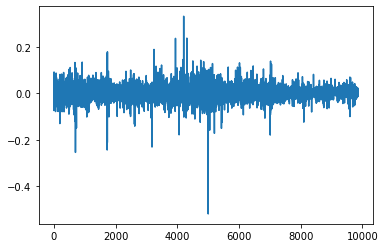

list index out of range


In [3]:
data = pd.read_csv('C:\AAPL.csv')#[::-1]
#data = data.loc[:, 'Adj Close'].tolist()


# Uncomment below to use price change time series
data = data.loc[:, 'Adj Close'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [4]:
model = Sequential()
model.add(Dense(64, input_dim=30, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(2))

model.add(Activation('linear')) #linear softmax

opt = Nadam(lr=0.001)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=25, min_lr=0.000001, verbose=1)

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='mean_squared_error', #mse mean_squared_error categorical_crossentropy
              metrics=['accuracy']) #mse accuracy

In [5]:
history = model.fit(X_train, Y_train, 
          epochs = 150,
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Train on 8843 samples, validate on 983 samples
Epoch 1/150
8843/8843 [==============================] - 1s 150us/step - loss: 61.1856 - accuracy: 0.5322 - val_loss: 28.7138 - val_accuracy: 0.5371

Epoch 00001: val_loss improved from inf to 28.71379, saving model to test.hdf5
Epoch 2/150
8843/8843 [==============================] - 0s 40us/step - loss: 28.9813 - accuracy: 0.5513 - val_loss: 12.9808 - val_accuracy: 0.5270

Epoch 00002: val_loss improved from 28.71379 to 12.98077, saving model to test.hdf5
Epoch 3/150
8843/8843 [==============================] - 0s 38us/step - loss: 13.5475 - accuracy: 0.5602 - val_loss: 5.5338 - val_accuracy: 0.5137

Epoch 00003: val_loss improved from 12.98077 to 5.53379, saving model to test.hdf5
Epoch 4/150
8843/8843 [==============================] - 0s 39us/step - loss: 6.2717 - accuracy: 0.5872 - val_loss: 2.2682 - val_accuracy: 0.5127

Epoch 00004: val_loss improved from 5.53379 to 2.26824, saving model to test.hdf5
Epoch 5/150
8843/8843 [========

8843/8843 [==============================] - 0s 39us/step - loss: 0.2063 - accuracy: 0.7199 - val_loss: 0.2227 - val_accuracy: 0.6928

Epoch 00039: val_loss did not improve from 0.20448
Epoch 40/150
8843/8843 [==============================] - 0s 40us/step - loss: 0.2098 - accuracy: 0.7159 - val_loss: 0.2097 - val_accuracy: 0.7152

Epoch 00040: val_loss did not improve from 0.20448
Epoch 41/150
8843/8843 [==============================] - 0s 40us/step - loss: 0.2091 - accuracy: 0.7164 - val_loss: 0.2184 - val_accuracy: 0.6775

Epoch 00041: val_loss did not improve from 0.20448
Epoch 42/150
8843/8843 [==============================] - 0s 38us/step - loss: 0.2064 - accuracy: 0.7251 - val_loss: 0.2181 - val_accuracy: 0.6877

Epoch 00042: val_loss did not improve from 0.20448
Epoch 43/150
8843/8843 [==============================] - 0s 39us/step - loss: 0.2079 - accuracy: 0.7177 - val_loss: 0.2165 - val_accuracy: 0.6999

Epoch 00043: val_loss did not improve from 0.20448
Epoch 44/150
8843/

8843/8843 [==============================] - 0s 39us/step - loss: 0.2060 - accuracy: 0.7190 - val_loss: 0.2085 - val_accuracy: 0.7131

Epoch 00079: val_loss did not improve from 0.20192
Epoch 80/150
8843/8843 [==============================] - 0s 39us/step - loss: 0.2059 - accuracy: 0.7156 - val_loss: 0.2081 - val_accuracy: 0.7050

Epoch 00080: val_loss did not improve from 0.20192
Epoch 81/150
8843/8843 [==============================] - 0s 40us/step - loss: 0.2078 - accuracy: 0.7164 - val_loss: 0.2131 - val_accuracy: 0.6877

Epoch 00081: val_loss did not improve from 0.20192
Epoch 82/150
8843/8843 [==============================] - 0s 39us/step - loss: 0.2070 - accuracy: 0.7134 - val_loss: 0.2284 - val_accuracy: 0.6572

Epoch 00082: val_loss did not improve from 0.20192
Epoch 83/150
8843/8843 [==============================] - 0s 39us/step - loss: 0.2109 - accuracy: 0.7156 - val_loss: 0.2058 - val_accuracy: 0.7162

Epoch 00083: val_loss did not improve from 0.20192
Epoch 84/150
8843/

8843/8843 [==============================] - 0s 40us/step - loss: 0.2042 - accuracy: 0.7181 - val_loss: 0.1980 - val_accuracy: 0.7192

Epoch 00119: val_loss did not improve from 0.19617
Epoch 120/150
8843/8843 [==============================] - 0s 40us/step - loss: 0.2036 - accuracy: 0.7172 - val_loss: 0.2015 - val_accuracy: 0.6979

Epoch 00120: val_loss did not improve from 0.19617
Epoch 121/150
8843/8843 [==============================] - 0s 40us/step - loss: 0.2034 - accuracy: 0.7228 - val_loss: 0.2032 - val_accuracy: 0.7121

Epoch 00121: val_loss did not improve from 0.19617
Epoch 122/150
8843/8843 [==============================] - 0s 40us/step - loss: 0.2049 - accuracy: 0.7212 - val_loss: 0.2057 - val_accuracy: 0.6989

Epoch 00122: val_loss did not improve from 0.19617
Epoch 123/150
8843/8843 [==============================] - 0s 40us/step - loss: 0.2054 - accuracy: 0.7144 - val_loss: 0.2151 - val_accuracy: 0.6989

Epoch 00123: val_loss did not improve from 0.19617
Epoch 124/150


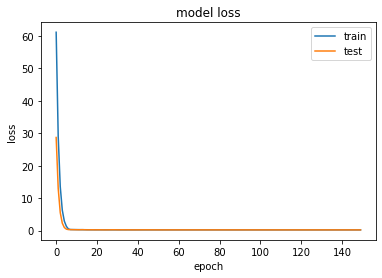

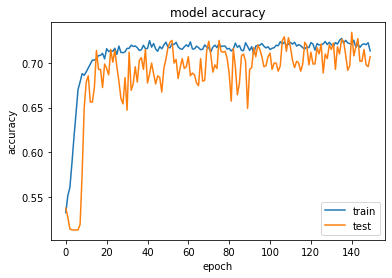

In [6]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

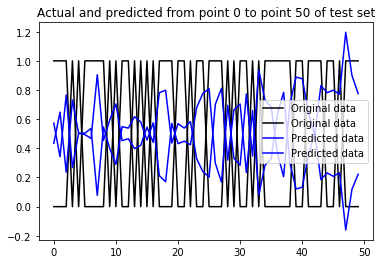

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

#print C / C.astype(np.float).sum(axis=1) #SyntaxError: invalid syntax

FROM = 0
TO = FROM + 500

original = Y_test[FROM:TO]
predicted = pred[FROM:TO] 

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted from point %d to point %d of test set' % (FROM, TO))
plt.show()